In [5]:
##################
### Authenticate
##################

import os
import json

# Literal contents of your kaggle.json file (replace with your own keys!)
kaggle_token = {
    "username": "sarnobat",
    "key": "335c6dd0bfa022bef08ce6af0b8d466c"
}

# Target directory and file path
kaggle_dir = os.path.expanduser("~/.kaggle")
kaggle_path = os.path.join(kaggle_dir, "kaggle.json")

# Ensure ~/.kaggle directory exists
os.makedirs(kaggle_dir, exist_ok=True)

# Write the JSON credentials to the file
with open(kaggle_path, "w") as f:
    json.dump(kaggle_token, f)

# Set file permissions to read/write for user only
os.chmod(kaggle_path, 0o600)

print(f"✅ Created {kaggle_path} with API key.")

✅ Created /root/.kaggle/kaggle.json with API key.


In [4]:
!pip install kaggle
!cat /root/.kaggle/kaggle.json

!mkdir /content/stock-time-series-20050101-to-20171231
!kaggle datasets download -d szrlee/stock-time-series-20050101-to-20171231
!unzip stock-time-series-20050101-to-20171231.zip -d /content/stock-time-series-20050101-to-20171231/

!find /content/stock-time-series-20050101-to-20171231/ -maxdepth 1 -iname "*csv"

{"username": "sarnobat", "key": "335c6dd0bfa022bef08ce6af0b8d466c"}Dataset URL: https://www.kaggle.com/datasets/szrlee/stock-time-series-20050101-to-20171231
License(s): CC0-1.0
  0% 0.00/3.03M [00:00<?, ?B/s]
100% 3.03M/3.03M [00:00<00:00, 670MB/s]
Archive:  stock-time-series-20050101-to-20171231.zip
  inflating: /content/stock-time-series-20050101-to-20171231/AABA_2006-01-01_to_2018-01-01.csv  
  inflating: /content/stock-time-series-20050101-to-20171231/AAPL_2006-01-01_to_2018-01-01.csv  
  inflating: /content/stock-time-series-20050101-to-20171231/AMZN_2006-01-01_to_2018-01-01.csv  
  inflating: /content/stock-time-series-20050101-to-20171231/AXP_2006-01-01_to_2018-01-01.csv  
  inflating: /content/stock-time-series-20050101-to-20171231/BA_2006-01-01_to_2018-01-01.csv  
  inflating: /content/stock-time-series-20050101-to-20171231/CAT_2006-01-01_to_2018-01-01.csv  
  inflating: /content/stock-time-series-20050101-to-20171231/CSCO_2006-01-01_to_2018-01-01.csv  
  inflating: /content/

In [6]:
import numpy as np
import pandas as pd

In [7]:
filepath = '/content/stock-time-series-20050101-to-20171231/AMZN_2006-01-01_to_2018-01-01.csv'
data = pd.read_csv(filepath)
data = data.sort_values('Date')
data.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
1,2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2,2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
3,2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
4,2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


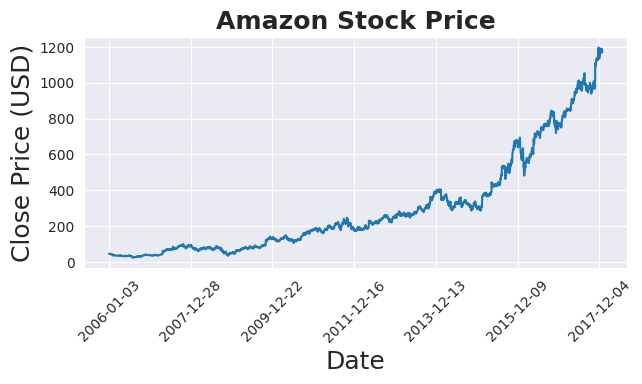

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.figure(figsize = (7,3))
plt.plot(data[['Close']])
plt.xticks(range(0,data.shape[0],500),data['Date'].loc[::500],rotation=45)
plt.title("Amazon Stock Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()


In [9]:
price = data[['Close']]
price.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3019 non-null   float64
dtypes: float64(1)
memory usage: 23.7 KB


In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

/tmp/ipython-input-68737012.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


In [11]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])

    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]

    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]

    return [x_train, y_train, x_test, y_test]


In [12]:
lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2399, 19, 1)
y_train.shape =  (2399, 1)
x_test.shape =  (600, 19, 1)
y_test.shape =  (600, 1)


In [13]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [14]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [15]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out


In [16]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)


In [17]:
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time
print("Training time: {} seconds".format(training_time))


Epoch  0 MSE:  0.3123970031738281
Epoch  1 MSE:  0.15050363540649414
Epoch  2 MSE:  0.03142629191279411
Epoch  3 MSE:  0.2718847692012787
Epoch  4 MSE:  0.04522452503442764
Epoch  5 MSE:  0.04277031496167183
Epoch  6 MSE:  0.07748614996671677
Epoch  7 MSE:  0.0986306443810463
Epoch  8 MSE:  0.10412101447582245
Epoch  9 MSE:  0.09870214760303497
Epoch  10 MSE:  0.08687134832143784
Epoch  11 MSE:  0.0722607746720314
Epoch  12 MSE:  0.057853568345308304
Epoch  13 MSE:  0.04609272629022598
Epoch  14 MSE:  0.038743410259485245
Epoch  15 MSE:  0.036553967744112015
Epoch  16 MSE:  0.038910873234272
Epoch  17 MSE:  0.043839167803525925
Epoch  18 MSE:  0.04865913465619087
Epoch  19 MSE:  0.05115222558379173
Epoch  20 MSE:  0.05050882697105408
Epoch  21 MSE:  0.047400522977113724
Epoch  22 MSE:  0.04328111186623573
Epoch  23 MSE:  0.039547648280858994
Epoch  24 MSE:  0.037044186145067215
Epoch  25 MSE:  0.035982582718133926
Epoch  26 MSE:  0.03611353784799576
Epoch  27 MSE:  0.03696256875991821


In [18]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))


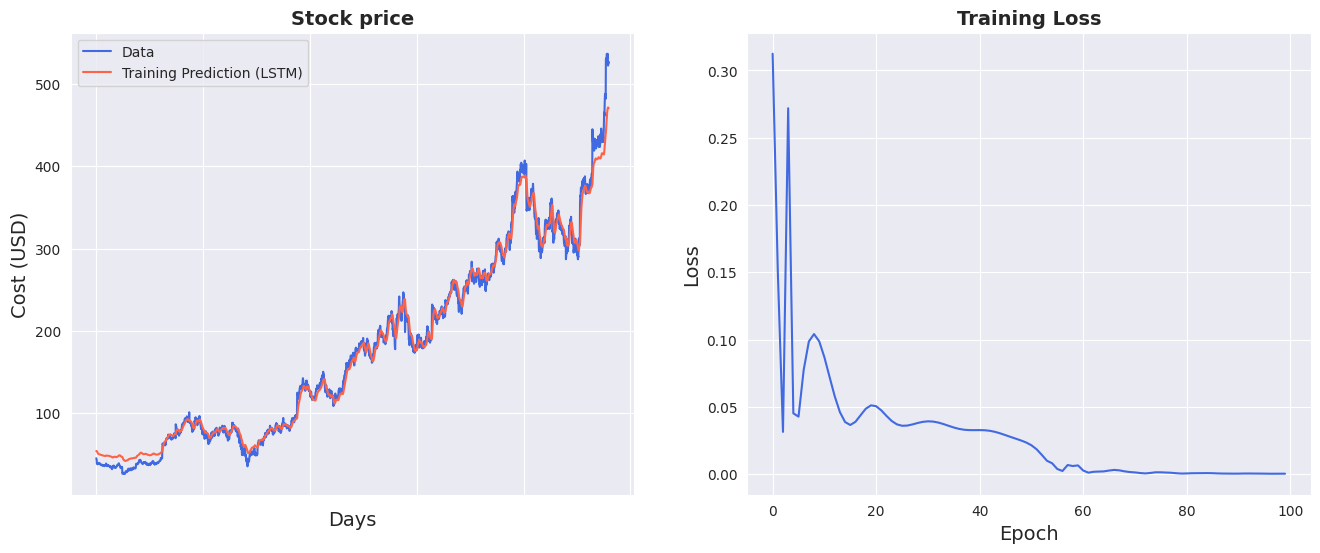

In [19]:
import seaborn as sns
sns.set_style("darkgrid")

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)


In [20]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)


Train Score: 11.29 RMSE
Test Score: 267.02 RMSE


In [21]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred

original = scaler.inverse_transform(price['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)


In [22]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    width=1200,
    height=800,
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='black',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='black',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='black',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='black',
        ),
    ),
    showlegend=True,
    template = 'plotly'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (LSTM)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()


In [23]:
!pip install chart-studio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 1.9 MB/s eta 0:00:00


In [24]:
import chart_studio.plotly as py
import chart_studio

chart_studio.tools.set_credentials_file(username='sarnobat', api_key='lUujJ4f0bzoTc6d86y1Q')
# py.iplot(fig, filename='stock_prediction_lstm')

fig = py.get_figure('sarnobat', 1)  # 'username', chart number
fig.update_layout(width=1200, height=800)
fig.show()

In [25]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :])
        return out


In [26]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)


In [27]:
hist = np.zeros(num_epochs)
start_time = time.time()
gru = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_gru)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time
print("Training time: {}".format(training_time))


Epoch  0 MSE:  0.4978374242782593
Epoch  1 MSE:  0.1166510060429573
Epoch  2 MSE:  0.05341893434524536
Epoch  3 MSE:  0.11265334486961365
Epoch  4 MSE:  0.04623907059431076
Epoch  5 MSE:  0.024941768497228622
Epoch  6 MSE:  0.0483996756374836
Epoch  7 MSE:  0.06148471310734749
Epoch  8 MSE:  0.05286377668380737
Epoch  9 MSE:  0.035927191376686096
Epoch  10 MSE:  0.024031639099121094
Epoch  11 MSE:  0.023206667974591255
Epoch  12 MSE:  0.030079055577516556
Epoch  13 MSE:  0.03541412949562073
Epoch  14 MSE:  0.03341697156429291
Epoch  15 MSE:  0.02647838182747364
Epoch  16 MSE:  0.020533395931124687
Epoch  17 MSE:  0.0189850851893425
Epoch  18 MSE:  0.02099568024277687
Epoch  19 MSE:  0.023343311622738838
Epoch  20 MSE:  0.02326079271733761
Epoch  21 MSE:  0.020265717059373856
Epoch  22 MSE:  0.01608988828957081
Epoch  23 MSE:  0.013245687820017338
Epoch  24 MSE:  0.013087145052850246
Epoch  25 MSE:  0.01444686483591795
Epoch  26 MSE:  0.014509984292089939
Epoch  27 MSE:  0.0119033278897

In [28]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_gru.detach().numpy()))


/tmp/ipython-input-3084955487.py:13: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



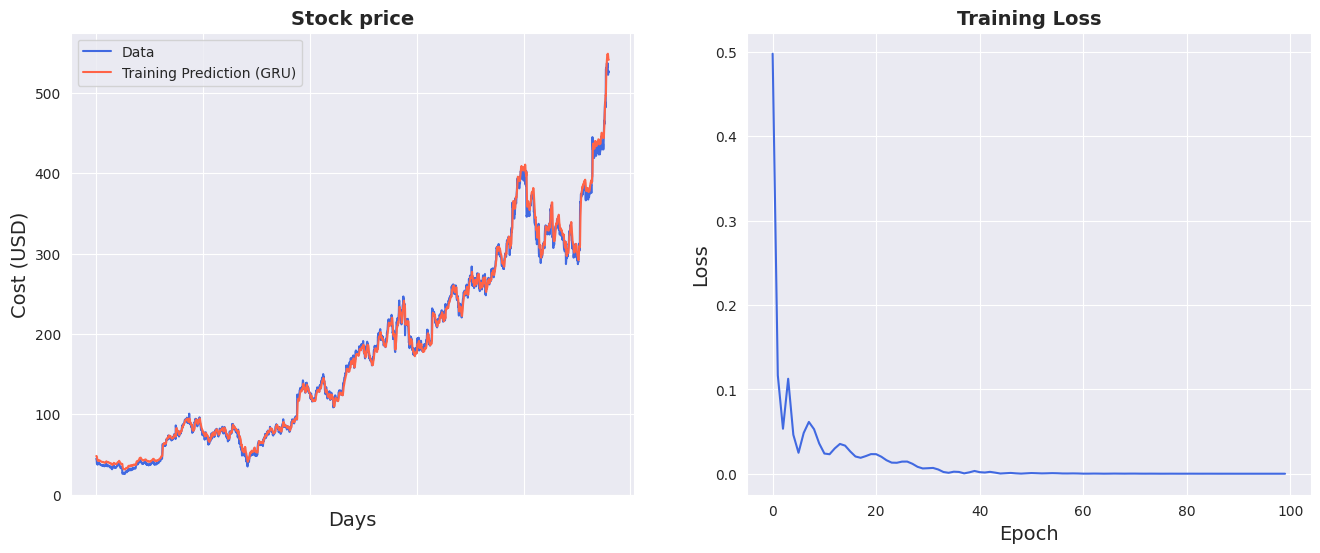

In [29]:
import seaborn as sns
sns.set_style("darkgrid")

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (GRU)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('x', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)


In [30]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_gru.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_gru.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
gru.append(trainScore)
gru.append(testScore)
gru.append(training_time)


Train Score: 6.06 RMSE
Test Score: 37.77 RMSE


In [31]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred

original = scaler.inverse_transform(price['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)


import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    width=1200,
    height=800,
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (GRU)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()


In [32]:
lstm = pd.DataFrame(lstm, columns=['LSTM'])
gru = pd.DataFrame(gru, columns=['GRU'])
result = pd.concat([lstm, gru], axis=1, join='inner')
result.index = ['Train RMSE', 'Test RMSE', 'Train Time']
result


,LSTM,GRU
Train RMSE,11.292426,6.061556
Test RMSE,267.015200,37.769539
Train Time,35.204961,29.535777


In [33]:
# py.iplot(fig, filename='stock_prediction_gru')

# fig = py.get_figure('sarnobat', 1)  # 'username', chart number
# fig.show()